# Bootstrap validation

This notebook contains code for validating the approximate bootstrap as well as generating half of figure 3 of the paper.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
from statsmodels.distributions.empirical_distribution import ECDF
import pickle as pkl
import time

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [5]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

In [6]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig3/'

### Validate the bootstrap outcomes for a single gene

Check the mean of the bootstrap distributions for mean and variance

In [297]:
true_data = simulate.simulate_transcriptomes(10000, 2000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = 'PBMC'

In [298]:
# Calculate the point estimates
size_factors = scdd.dd_size_factor(adata)
Nr = adata.X.sum(axis=1).mean()
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors, verbose=False, Nr=Nr)
var_scdd = scdd.M_to_var(M_dd)

In [368]:
# Get info for a single gene
gene_idx = 9

data = adata.X[:, gene_idx].todense().A1
sparse_data = adata.X[:, gene_idx]
all_sf = size_factors
normalized_data = data/all_sf/Nr
unique_count = np.unique(data).shape[0]
num_boot = 50000
print('This gene has {} unique counts.'.format(unique_count))

This gene has 59 unique counts.


(array([ 428., 2016., 2990., 2301., 1339.,  615.,  207.,   69.,   26.,
           9.]),
 array([ 1. ,  7.2, 13.4, 19.6, 25.8, 32. , 38.2, 44.4, 50.6, 56.8, 63. ],
       dtype=float32),
 <a list of 10 Patch objects>)

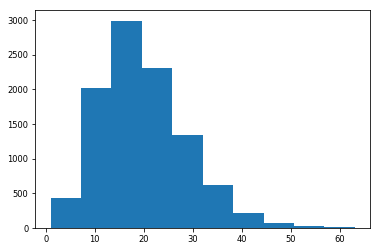

In [369]:
plt.hist(data)

In [370]:
%%time
# Perform true bootstrap
real_boot_mean_dist = np.zeros(num_boot)
real_boot_var_dist = np.zeros(num_boot)
for boot in range(num_boot):
    
    boot_idx = np.random.choice(data.shape[0], data.shape[0])
    res = estimator._poisson_1d(sparse_data[boot_idx], data.shape[0], size_factor=all_sf[boot_idx], n_umi=Nr)
    real_boot_mean_dist[boot] = res[0][0]
    real_boot_var_dist[boot] = res[1][0]

CPU times: user 38.8 s, sys: 0 ns, total: 38.8 s
Wall time: 38.8 s


In [371]:
%%time
imp.reload(bootstrap)
num_bins_list = [5, 10, 30, 60]
approx_boot_dists = []
for num_bins in num_bins_list:

    approx_boot_dists.append(bootstrap._bootstrap_1d(
        data=sparse_data,
        size_factor=all_sf, 
        true_mean=M_dd[0][gene_idx], 
        true_var=var_scdd[gene_idx], 
        num_boot=num_boot, 
        n_umi=Nr, 
        log=False,
        bins=num_bins))  

CPU times: user 3.99 s, sys: 1.25 s, total: 5.24 s
Wall time: 5.24 s


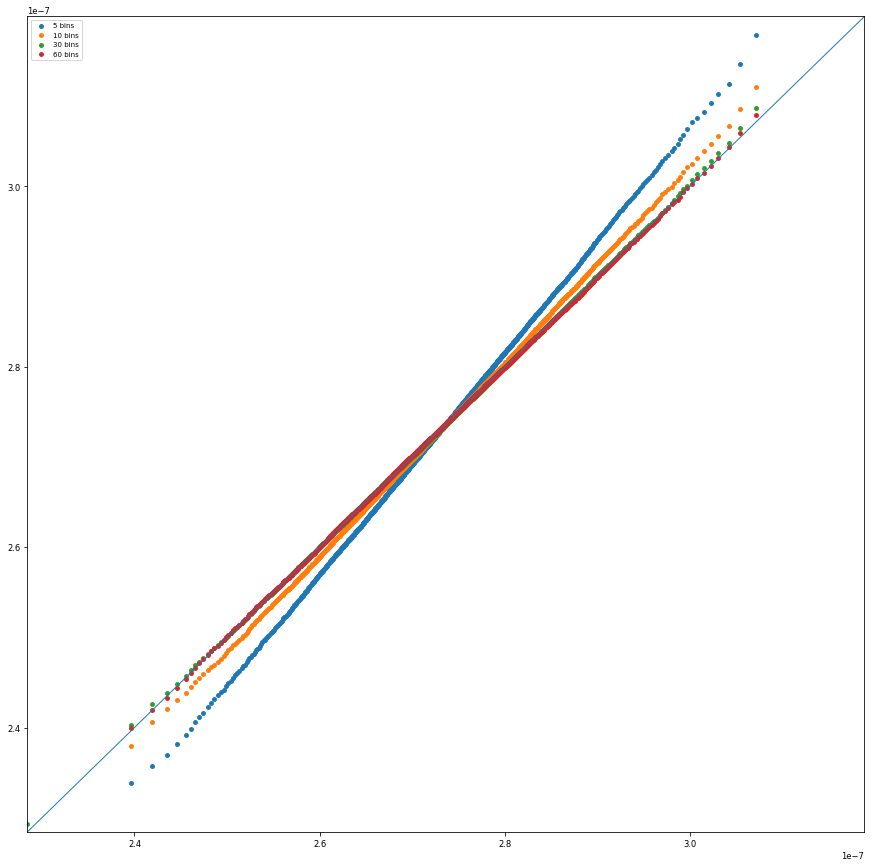

In [372]:
plt.figure(figsize=(15, 15))
for idx, num_bins in enumerate(num_bins_list):
    plt.scatter(
        np.quantile(np.sort(real_boot_var_dist), np.linspace(0, 1, 1000)),
        np.quantile(np.sort(approx_boot_dists[idx][1]), np.linspace(0, 1, 1000)),
        label='{} bins'.format(num_bins),
        s=15,
    )

plt.plot(np.sort(real_boot_var_dist), np.sort(real_boot_var_dist), lw=1)
plt.xlim(6.9e-8, 9.9e-8);
plt.ylim(6.9e-8, 9.9e-8)

plt.xlim(real_boot_var_dist.min(), real_boot_var_dist.max())
plt.ylim(real_boot_var_dist.min(), real_boot_var_dist.max())

plt.legend()

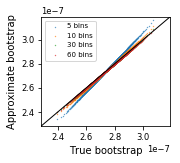

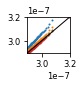

In [380]:
plt.figure(figsize=(2.3, 2))

for idx, num_bins in enumerate(num_bins_list):
    plt.scatter(
        np.quantile(np.sort(real_boot_var_dist), np.linspace(0, 1, 1000)),
        np.quantile(np.sort(approx_boot_dists[idx][1]), np.linspace(0, 1, 1000)),
        label='{} bins'.format(num_bins),
        s=0.1,
    )

plt.plot(np.sort(real_boot_var_dist), np.sort(real_boot_var_dist), lw=1, color='k')
plt.xlim(real_boot_var_dist.min(), real_boot_var_dist.max())
plt.ylim(real_boot_var_dist.min(), real_boot_var_dist.max())
plt.legend()
plt.ylabel('Approximate bootstrap'); plt.xlabel('True bootstrap');
plt.savefig(fig_path + 'bootstrap_ecdf_var_large.pdf', bbox_inches='tight')

plt.figure(figsize=(2.3/3, 2/3))

for idx, num_bins in enumerate(num_bins_list):
    plt.scatter(
        np.quantile(np.sort(real_boot_var_dist), np.linspace(0, 1, 1000)),
        np.quantile(np.sort(approx_boot_dists[idx][1]), np.linspace(0, 1, 1000)),
        label='{} bins'.format(num_bins),
        s=1,
    )
plt.plot(np.sort(real_boot_var_dist), np.sort(real_boot_var_dist), lw=1, color='k')

plt.xlim(2.9e-7, 3.2e-7);
plt.ylim(2.9e-7, 3.2e-7)
plt.savefig(fig_path + 'bootstrap_ecdf_var_small.pdf', bbox_inches='tight')


### Validate the bootstrap outcomes for a single pair of genes

Check the mean of the bootstrap distributions for correlation

In [204]:
true_data = simulate.simulate_transcriptomes(10000, 2000, correlated=True)
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = 'PBMC'

In [268]:
# Get info for a single pair of gene
gene_idx_1 = 0
gene_idx_2 = 3
gene_idxs = [gene_idx_1, gene_idx_2]

data = adata.X[:, gene_idxs].toarray()
sparse_data = adata.X[:, gene_idxs]
all_sf = size_factors
normalized_data = data/all_sf.reshape(-1, 1)/Nr
unique_count = np.unique(data, axis=0).shape[0]
num_boot = 10000
print('This gene has {} unique counts.'.format(unique_count))

This gene has 303 unique counts.


In [269]:
np.unique(data[:, 0]).shape

(8,)

In [270]:
np.unique(data[:, 1]).shape

(90,)

In [271]:
# Calculate the point estimates
size_factors = scdd.dd_size_factor(adata)
Nr = adata.X.sum(axis=1).mean()
true_mean, true_var = estimator._poisson_1d(sparse_data, data.shape[0], size_factor=all_sf, n_umi=Nr)
true_cov = estimator._poisson_cov(sparse_data, data.shape[0], size_factor=all_sf, n_umi=Nr)[0, 1]
true_corr = true_cov/np.sqrt(true_var[0]*true_var[1])

In [272]:
%%time
# Perform true bootstrap
imp.reload(estimator)
real_boot_corr_dist = np.zeros(num_boot)
real_boot_cov_dist = np.zeros(num_boot)

for boot in range(num_boot):
    
    boot_idx = np.random.choice(data.shape[0], data.shape[0])
    boot_mean, boot_var = estimator._poisson_1d(sparse_data[boot_idx], data.shape[0], size_factor=all_sf[boot_idx], n_umi=Nr)
    cov = estimator._poisson_cov(sparse_data[boot_idx], data.shape[0], size_factor=all_sf[boot_idx], n_umi=Nr)[1, 0]
    real_boot_corr_dist[boot] = estimator._corr_from_cov(cov, boot_var[0], boot_var[1])
    real_boot_cov_dist[boot] = cov

CPU times: user 43 s, sys: 1.86 ms, total: 43 s
Wall time: 43 s


In [292]:
%%time
imp.reload(bootstrap)
num_bins_list = [1, 5, 10, 90, 100]
approx_boot_dists = []
for num_bins in num_bins_list:

    approx_boot_dists.append(bootstrap._bootstrap_2d(
        data=sparse_data,
        size_factor=all_sf,
        true_cov=true_cov,
        true_corr=true_corr,
        num_boot=num_boot, 
        n_umi=Nr, 
        bins=num_bins))  


CPU times: user 4.37 s, sys: 1.82 s, total: 6.2 s
Wall time: 6.19 s


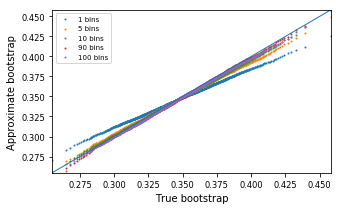

In [296]:
plt.figure(figsize=(5, 3))

for idx, num_bins in enumerate(num_bins_list):
    plt.scatter(
        np.quantile(np.sort(real_boot_corr_dist), np.linspace(0, 1, 1000)),
        np.quantile(np.sort(approx_boot_dists[idx][1]), np.linspace(0, 1, 1000)),
        label='{} bins'.format(num_bins),
        s=1,
    )

plt.plot(np.sort(real_boot_corr_dist), np.sort(real_boot_corr_dist), lw=1)
plt.legend()
plt.ylabel('Approximate bootstrap'); plt.xlabel('True bootstrap');
# plt.xlim(0.5e-8, 0.7e-8)
# plt.ylim(0.5e-8, 0.7e-8)
plt.xlim(real_boot_corr_dist.min(), real_boot_corr_dist.max())
plt.ylim(real_boot_corr_dist.min(), real_boot_corr_dist.max())
plt.savefig(fig_path + 'bootstrap_ecdf_corr.pdf', bbox_inches='tight')

# plt.xlim(0.15, 0.2);
# plt.ylim(0.15, 0.2)

### Timing analysis with increasing cell numbers 1D

In [135]:
# Generate cell sizes
num_cells = 2000000
cell_sizes = np.exp(stats.norm.rvs(11, 0.2, num_cells)).astype(int)

# Generate true expression of a single gene
mean = np.exp(2)
residual_variance = np.exp(3)
variance = mean*residual_variance
dispersion = (variance - mean)/mean**2
theta = 1/dispersion
print('mean', mean, 'dispersion', dispersion)
expr = stats.nbinom.rvs(*simulate.convert_params(mean, theta), size=num_cells)

# Generate the q's
q = 0.07
q_sq = 0.005
m = q
v = q_sq - q**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)
qs = stats.beta.rvs(alpha, beta, size=num_cells)

# Generate the observed distribution
obs_expr = stats.hypergeom.rvs(M=cell_sizes, n=expr, N=(qs*cell_sizes).astype(int))
obs_cell_sizes = (qs*cell_sizes).astype(int)

print('unique count', np.unique(obs_expr).shape)

mean 7.38905609893065 dispersion 2.5829465452224327
unique count (25,)


In [259]:
imp.reload(bootstrap)
times = []
boot_dists = []
sample_count_list = np.logspace(2, 6.2, 10)
for sample_count in sample_count_list:
    
    sample_idx = np.random.choice(num_cells, int(sample_count))
    sampled_obs_expr = obs_expr[sample_idx]
    sampled_obs_cell_sizes = obs_cell_sizes[sample_idx]
    
    n_umi = sampled_obs_cell_sies.mean()
    size_factors = sampled_obs_cell_sizes/sampled_obs_cell_sizes.mean()
    
    data = sp.sparse.csc_matrix(sampled_obs_expr.reshape(-1, 1))
    
    true_mean, true_var = estimator._poisson_1d(data, data.shape[0], size_factor=size_factors, n_umi=n_umi)
    times.append(bootstrap._bootstrap_1d(
        data=data,
        size_factor=size_factors, 
        true_mean=true_mean[0], 
        true_var=true_var[0], 
        num_boot=30000, 
        n_umi=n_umi, 
        log=False,
        return_times=True))
    boot_dists.append(bootstrap._bootstrap_1d(
        data=data,
        size_factor=size_factors, 
        true_mean=true_mean[0], 
        true_var=true_var[0], 
        num_boot=30000, 
        n_umi=n_umi, 
        log=False,
        return_times=False))

In [260]:
count_times = [i[1]-i[0] for i in times]
boot_times = [i[2]-i[1] for i in times]
all_times = [i[2]-i[0] for i in times]

Text(0, 0.5, 'Runtime (seconds)')

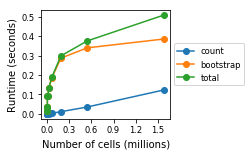

In [261]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)
plt.figure(figsize=(2.3, 2))

plt.plot(sample_count_list/1e6, count_times, '-o')
plt.plot(sample_count_list/1e6, boot_times, '-o')
plt.plot(sample_count_list/1e6, all_times, '-o')
plt.legend(['count', 'bootstrap', 'total'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.3))
plt.xlabel('Number of cells (millions)'); plt.ylabel('Runtime (seconds)')
# plt.savefig(fig_path + 'bootstrap_runtime.pdf', bbox_inches='tight')

In [302]:
imp.reload(bootstrap)
times = []
boot_dists = []
sample_count_list = np.logspace(2, 6.2, 10)
for sample_count in sample_count_list:
    
    sample_idx = np.random.choice(num_cells, int(sample_count))
    sampled_obs_expr = obs_expr[sample_idx]
    sampled_obs_cell_sizes = obs_cell_sizes[sample_idx]
    
    n_umi = sampled_obs_cell_sizes.mean()
    size_factors = sampled_obs_cell_sizes/sampled_obs_cell_sizes.mean()
    
    data = sp.sparse.csc_matrix(sampled_obs_expr.reshape(-1, 1))
    
    true_mean, true_var = estimator._poisson_1d(data, data.shape[0], size_factor=size_factors, n_umi=n_umi)
    boot_dists.append(bootstrap._bootstrap_1d(
        data=data,
        size_factor=size_factors, 
        true_mean=true_mean[0], 
        true_var=true_var[0], 
        num_boot=30000, 
        n_umi=n_umi, 
        log=False,
        return_times=False))

In [303]:
true_mean_all_cells, true_var_all_cells = estimator._poisson_1d(
    sp.sparse.csc_matrix(obs_expr.reshape(-1, 1)), 
    obs_expr.shape[0], size_factor=obs_cell_sizes/obs_cell_sizes.mean(), n_umi=n_umi)

7356.422544596414
21544.346900318866
63095.7344480193
184784.97974222907
541169.5265464637


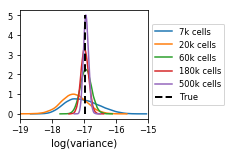

In [309]:
labels = ['7k', '20k', '60k', '180k', '500k']
plt.figure(figsize=(2.3, 2))

for idx, sample_count in enumerate(sample_count_list[4:9]):
    print(sample_count)
    dist = np.log(boot_dists[idx][1])
#     dist = dist[(dist < -50) & (dist > -51)]
    sns.distplot(dist, hist=False, label='{} cells'.format(labels[idx]))
plt.xlim(-19, -15)
plt.xlabel('log(variance)')
plt.plot([np.log(true_var_all_cells), np.log(true_var_all_cells)], [0, 5], color='k', lw=2, linestyle='--', label='True')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(fig_path + 'bootstrap_distribution.pdf', bbox_inches='tight')